Three questions asked:
    - Which areas and counties are the biggest producers, produce high score wine
    - APA wines are better than other  regions wines
    - Difference between white and red wines

#### Wine Database

http://users.csc.calpoly.edu/%7Edekhtyar/365-Winter2015/index.html

In [19]:
!cat README.WINE.txt | head -n 15 # run without | head to read the explanations











Sources:  This dataset contains wine ratings from a






  The dataset consists of the following files:

     - appelations.csv  : list of appelations/American Viticultural Areas (AVAs)
     - grapes.csv       : list of grape varieties
     - wine.csv         : list of wines and their ratings


 Individual files have the following formats.

**************************************************************************

appelations.csv

          No : line number in the CSV file  
   Appelation: name of the appelation/AVA/grape-growing region
       County: county (if applicable) in which the area is located
        State: state in which the area is located
         Area: general geographic area in which the grape-growing region is located
        isAVA: a flag specifying whether the region is recognized as an American
               Viticultural Area (AVA) by federal regulations.


**************************************************************************

grapes.csv

     ID: unique identifier of a grape (line number in the CSV file)
      Grape: name of the grape varietal
      Color: color of the grape (a.k.a, color of the wine when made solely of
         this grape)

**************************************************************************

wine.csv

       No.: unique identifier of the wine (line number in the CSV file)
     Grape: grape varietal from which the wine is made (see grapes.Grape)
    Winery: maker of the wine (usually a winery name)
    Appelation: origin of the grapes (see applations.Appelation)
     State: state of the grapes' origin (same as appelations.State)
      Name: name of the wine
      Year: year of the wine vintage
     Price: price of one bottle of wine in (whole) US dollars
     Score: Wine Spectator magazine rating of the wine on the 100 point scale
     Cases: number of cases of the wine produced by its maker
     Drink: drinking advice


# Create DB

In [20]:
!psql -c 'DROP DATABASE IF EXISTS winedb;' postgres

DROP DATABASE


In [21]:
! psql -c 'CREATE DATABASE winedb;' postgres

CREATE DATABASE


In [22]:
# check the databases
! psql -l

                                  List of databases
   Name    |  Owner   | Encoding |   Collate   |    Ctype    |   Access privileges   
-----------+----------+----------+-------------+-------------+-----------------------
 itunes    | samet    | UTF8     | en_US.UTF-8 | en_US.UTF-8 | 
 postgres  | postgres | UTF8     | en_US.UTF-8 | en_US.UTF-8 | 
 template0 | postgres | UTF8     | en_US.UTF-8 | en_US.UTF-8 | =c/postgres          +
           |          |          |             |             | postgres=CTc/postgres
 template1 | postgres | UTF8     | en_US.UTF-8 | en_US.UTF-8 | =c/postgres          +
           |          |          |             |             | postgres=CTc/postgres
 testdb    | samet    | UTF8     | en_US.UTF-8 | en_US.UTF-8 | 
 winedb    | samet    | UTF8     | en_US.UTF-8 | en_US.UTF-8 | 
(6 rows)



## Create Tables

In [23]:
import psycopg2
import csv 

In [24]:
con = psycopg2.connect(database='winedb', user='samet' , host='/var/run/postgresql/')  
cur = con.cursor()

with open ('grapes.csv', 'r') as f:
    reader = csv.reader(f)
    columns = next(reader) 
    cur.execute ('''
    DROP TABLE IF EXISTS grapes;
    CREATE TABLE Grapes ( 
        ID SERIAL PRIMARY KEY ,
        Grape TEXT UNIQUE ,
        Color TEXT)''' )  
    query = 'insert into grapes (ID, Grape, Color) values (%s, %s, %s)'
    for data in reader:
        cur.execute(query, [e.strip("'") for e in data])
    con.commit()
con.close()

In [25]:
# # check the tables created in the database
# !psql -c '\dt' winedb 
# !psql -c 'select * from grapes limit 5' winedb 

In [26]:
con = psycopg2.connect(database='winedb', user='samet' , host='/var/run/postgresql/')  
cur = con.cursor()

with open ('appellations.csv', 'r') as f:
    reader = csv.reader(f)
    columns = next(reader) 
    cur.execute ('''
    DROP TABLE IF EXISTS appelations;
    CREATE TABLE Appelations ( 
        ID SERIAL PRIMARY KEY ,
   Appelation TEXT,
       County TEXT,
        State TEXT,
         Area TEXT,
        isAVA TEXT)
        ''' )  
    query = 'insert into appelations (ID, Appelation, County, State, Area, isAVA )\
    values (%s, %s, %s, %s, %s, %s)'
    for data in reader:
        cur.execute(query, [e.strip("'") for e in data])
    con.commit()
con.close()

In [27]:
# # check the tables created in the database
# !psql -c '\dt' winedb 
# !psql -c 'select * from appelations limit 5' winedb 

In [28]:
con = psycopg2.connect(database='winedb', user='samet' , host='/var/run/postgresql/')  
cur = con.cursor()

with open ('wine.csv', 'r') as f:
    reader = csv.reader(f)
    columns = next(reader) 
    cur.execute ('''
    DROP TABLE IF EXISTS wine;
    CREATE TABLE wine ( 
        ID SERIAL PRIMARY KEY ,
     Grape TEXT,
    Winery TEXT,
Appelation TEXT,
     State TEXT,
      Name TEXT,
      Year INTEGER,
     Price INTEGER,
     Score INTEGER,
     Cases TEXT,
     Drink TEXT )
        ''' )  
    query = 'insert into wine (ID, Grape, Winery,Appelation, State, Name, Year, Price, Score, Cases, Drink)\
    values (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s) '
    for data in reader:
        cur.execute(query, [e.strip("'") for e in data])
    con.commit()
con.close()

In [29]:
# # check the tables created in the database
# !psql -c '\dt' winedb 
# !psql -c 'select * from wine limit 5' winedb 

# Playing with SQL

## Table & Data Manipulation 

In [30]:
!psql -c 'select distinct state from appelations ' winedb 
!psql -c 'select distinct state from wine ' winedb 

   state    
------------
 California
(1 row)

   state    
------------
 California
(1 row)



In [31]:
# since there is only one value for the state its better to drop the column
!psql -c 'alter table appelations drop column if exists state' winedb
!psql -c 'alter table wine drop column if exists state ' winedb

ALTER TABLE
ALTER TABLE


Drinking advice is simplified. Either the field contains the value 'now' which means that wine can be enjoyed to its fullest potential at the moment it was rated by the Wine Spectator magazine, or it contains a year in which the wine is predicted to reach its full potential.
So some wines should be consumed fresh and some mature. I will replace the values other than now as later to make the analysis more simple.

In [32]:
!psql -c "update wine set drink = 'later' where drink != 'now'" winedb
!psql -c "select distinct drink from wine" winedb

UPDATE 34
 drink 
-------
 now
 later
(2 rows)



Finally, get rif of the null values at cases and change the data type to integer

In [33]:
!psql -c "update wine set cases = '0' where cases = 'NULL'" winedb
!psql -c "alter table wine alter column cases set data type integer USING cases::integer" winedb

UPDATE 14
ALTER TABLE


## Quick Analysis

In [491]:
# check the column names
# !psql -c '\d grapes' winedb 
# !psql -c '\d wine' winedb 
# !psql -c '\d appelations' winedb 

## General Look to Grape and Wine Production

Most of the grapes are cultivated in Nort Coast and Central Cost areas respectively.

Sonoma and Napa are the counties with the highest number of the appelations. 

In [36]:
!psql -c "select county,count(county),area \
        from appelations \
        group by county,area \
        order by count desc \
        limit 5" winedb

     county      | count |       area       
-----------------+-------+------------------
 Sonoma          |    11 | North Coast
 Napa            |    11 | North Coast
 Santa Barbara   |     5 | Central Coast
 San Luis Obispo |     4 | Central Coast
 Amador          |     3 | Sierra Foothills
(5 rows)



Chardonnay and Sauvignon Blanc are the most frequently used grapes for white wines. 

Pinot Noir, Zinfandel, Cabernet Sauvingnon and Cabernet Sauvingnon are the most populer grapes for the red wines.

In [37]:
!psql -c "select wine.grape as grapes_white, count (wine.grape) \
        from wine join grapes\
        on wine.grape = grapes.grape\
        where grapes.color = 'White'\
        group by wine.grape\
        order by count desc" winedb

!psql -c "select wine.grape as grapes_red, count (wine.grape) \
        from wine join grapes\
        on wine.grape = grapes.grape\
        where grapes.color = 'Red'\
        group by wine.grape\
        order by count desc\
        limit 5" winedb

  grapes_white   | count 
-----------------+-------
 Chardonnay      |   104
 Sauvignon Blanc |    46
 Marsanne        |     1
 Roussanne       |     1
 Viognier        |     1
(5 rows)

     grapes_red      | count 
---------------------+-------
 Pinot Noir          |   109
 Zinfandel           |    78
 Cabernet Sauvingnon |    68
 Syrah               |    61
 Merlot              |    10
(5 rows)



## AVA wines are better?

AVA's are designated wine grape-growing regions in the United States which are regulated by the government. It is similar to DOC (controlled designation of origin) which is a quality assurance label for Italian wines. I remember from Italy that DOC wines were better and you had pay a little premium. Let's see if its the same with AVA wines. 


At a first glance, wines from AVA are more expensive and have higher score in average.


In [38]:
!psql -c  "select appelations.isava,count(appelations.isava),\
            round(avg(score),4) as average_score, round(avg(price),4) as average_price \
            from appelations join wine on appelations.appelation=wine.appelation\
            group by appelations.isava\
            order by average_score desc" winedb 

 isava | count | average_score | average_price 
-------+-------+---------------+---------------
 Yes   |   404 |       90.3490 |       47.8218
 No    |    96 |       88.8021 |       35.2396
(2 rows)



## Comparing Red or White Wines

In general white wines are cheaper for two reasons; first, red wines have more flavor elements in them than white wines do, due to the compounds that come from the skins and seeds. That allows red wines to age more than whites do. Second, white wine - especially the simpler varieties like Sauvignon Blanc are very economical to produce.

In case of California wines, it is the same. White wines seems significantly cheaper than red wines. But they both have similar scores in terms of taste. 

Even the number of red wine producers is more than double the white wine producers, white wine production exceeds the red wine in terms of volume of cases.

In [40]:
!psql -c  "select grapes.color, sum(wine.cases) as production,count(color), round(avg(price),4) as average_price, round(avg(score),4) as average_score\
            from grapes join wine on grapes.grape=wine.grape\
            group by grapes.color" winedb 

 color | production | count | average_price | average_score 
-------+------------+-------+---------------+---------------
 White |    1127718 |   153 |       36.8497 |       90.1961
 Red   |    1035506 |   347 |       49.1787 |       89.9885
(2 rows)



But the production volume data is not reliable since 12 of the red wine producer's output volume data is missing while only 2 is missing in terms of white. Nevertheless, average production volume of red and white wineries state that white wine producers produce more than double in average. This may be due to fact that producing white wine is cheaper and people prefer to consume more since it is more fresh, used during cooking, and white wine is the ingredient of lots of coctails.

In [53]:
!psql -c  "select grapes.color, count(wine.cases) as no_missing_info\
            from grapes join wine on grapes.grape=wine.grape\
            where wine.cases = 0\
            group by grapes.color" winedb 

!psql -c  "select grapes.color, round(avg(wine.cases),2) as avg_production \
            from grapes join wine on grapes.grape=wine.grape\
            where wine.cases != 0\
            group by grapes.color" winedb 

 color | no_missing_info 
-------+-----------------
 Red   |              12
 White |               2
(2 rows)

 color | avg_production 
-------+----------------
 White |        7468.33
 Red   |        3091.06
(2 rows)



# Statistical Tests and Analysis

#### Importing Data to Pandas Dataframe

In [54]:
# create a virtual table called data
!psql -c  "drop view if exists data" winedb 
!psql -c  "create view data as \
           select w.id,g.grape, g.color, w.name, a.area, a.county, w.winery, w.appelation, a.isava,  w.year ,w.drink,w.cases,w.price, w.score \
           from grapes as g, wine as w, appelations as a \
           where g.grape=w.grape and w.appelation = a.appelation\
           order by w.id" winedb 

NOTICE:  view "data" does not exist, skipping
DROP VIEW
CREATE VIEW


In [55]:
!psql -c "\d data" winedb

        View "public.data"
   Column   |  Type   | Modifiers 
------------+---------+-----------
 id         | integer | 
 grape      | text    | 
 color      | text    | 
 name       | text    | 
 area       | text    | 
 county     | text    | 
 winery     | text    | 
 appelation | text    | 
 isava      | text    | 
 year       | integer | 
 drink      | text    | 
 cases      | integer | 
 price      | integer | 
 score      | integer | 



In [2]:
import pandas as pd
import psycopg2
import pandas.io.sql as psql

# convert data to pandas dataframe
con = psycopg2.connect(database='winedb', user='samet', host='/var/run/postgresql/')
df = psql.read_sql("SELECT * FROM data", con)

In [180]:
df.head()

,id,grape,color,name,area,county,winery,appelation,isava,year,drink,cases,price,score
0,1,Zinfandel,Red,Old Kraft Vineyard,North Coast,Napa,Robert Biale,St. Helena,Yes,2008,now,275,44,93
1,2,Zinfandel,Red,Giana,North Coast,Napa,Chiarello Family,Napa Valley,Yes,2008,now,480,35,93
2,3,Zinfandel,Red,Black Chicken,North Coast,Napa,Robert Biale,Napa Valley,Yes,2008,later,2700,40,91
3,4,Zinfandel,Red,Napa Ranches,North Coast,Napa,Robert Biale,Napa Valley,Yes,2008,now,525,38,89
4,5,Zinfandel,Red,Varozza Vineyard,North Coast,Napa,Robert Biale,St. Helena,Yes,2008,later,275,44,88


#### Sanity Check

In [1]:
import scipy.stats as stat
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In [370]:
df.groupby(['area','county']).mean()

id         year         cases  \
area                 county                                                   
California           N/A              273.896552  2007.586207  19791.931034   
Central Coast        Monterey         191.125000  2008.083333   1966.166667   
                     N/A               93.000000  2008.000000  36000.000000   
                     San Benito       248.333333  2005.333333    776.000000   
                     San Luis Obispo  272.050000  2007.550000   1669.300000   
                     Santa Barbara    158.612245  2007.816327   1816.571429   
Central Valley       San Joaquin      280.500000  2006.500000  10225.000000   
                     Yolo             214.000000  2005.000000   1125.000000   
N/A                  N/A              483.000000  2008.000000   5856.000000   
North Coast          Lake             296.375000  2006.875000    980.375000   
                     Mendocino        268.666667  2006.500000   5533.000000   
                     N/A              172.000000  2007.666667  12033.333333   
                     Napa             244.335570  2006.966443   4149.973154   
                     Solano           172.000000  2007.000000    735.000000   
                     Sonoma           269.596774  2007.424731   3353.193548   
Santa Cruz Mountains Alameda          464.000000  2007.000000    456.000000   
                     Contra Costa     463.600000  2007.400000   1429.800000   
                     N/A              269.000000  2007.000000    400.000000   
Sierra Foothills     Amador           295.375000  2006.625000   3249.000000   
                     Calaveras        386.000000  2006.000000      0.000000   
                     N/A              389.000000  2006.000000      0.000000   

                                          price      score  
area                 county                                 
California           N/A              39.482759  87.827586  
Central Coast        Monterey         43.416667  91.083333  
                     N/A              13.000000  87.000000  
                     San Benito       38.333333  90.666667  
                     San Luis Obispo  31.800000  88.950000  
                     Santa Barbara    40.591837  89.836735  
Central Valley       San Joaquin      21.500000  87.500000  
                     Yolo             25.000000  91.000000  
N/A                  N/A              18.000000  87.000000  
North Coast          Lake             31.000000  87.875000  
                     Mendocino        34.333333  89.333333  
                     N/A              15.000000  85.666667  
                     Napa             57.476510  90.416107  
                     Solano           35.000000  89.000000  
                     Sonoma           43.500000  90.618280  
Santa Cruz Mountains Alameda          40.000000  89.000000  
                     Contra Costa     27.800000  87.200000  
                     N/A              40.000000  93.000000  
Sierra Foothills     Amador           29.875000  88.000000  
                     Calaveras        20.000000  84.000000  
                     N/A              10.000000  82.000000

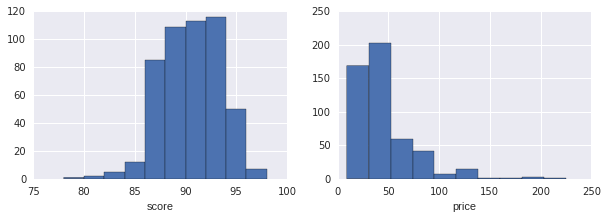

In [364]:
fig,ax = plt.subplots(1,2,figsize=(10,3))
ax[0].hist(df.score)
ax[0].set_xlabel('score')
ax[1].hist(df.price)
ax[1].set_xlabel('price');

In [368]:
w_price,p_price = stat.shapiro(df.price)
w_score,p_score = stat.shapiro(df.score)
w_price,p_price,w_score,p_score

(0.8181392550468445,
 2.3269743251562505e-23,
 0.9752002954483032,
 1.703658654150786e-07)

Both score and price data are not distributed normally. Price data is positively skewed. 

## 1. General Look to Grape and Wine Production

### 1. i. Price Analysis

#### By Area

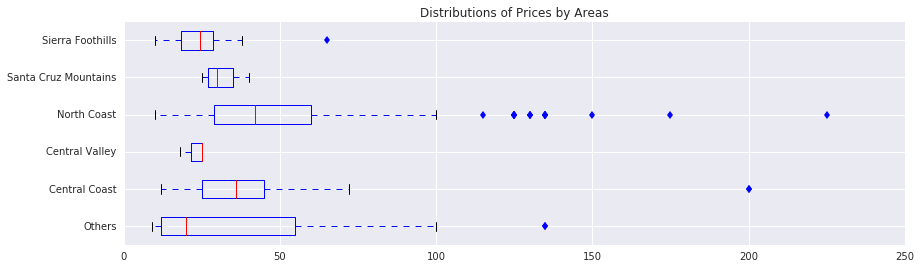

In [365]:
fig,ax = plt.subplots(figsize=(14,4))
ax.set_title('Distributions of Prices by Areas')
ax.boxplot([df[df.area == 'California']['price'].values,
            df[df.area == 'Central Coast']['price'].values,
            df[df.area == 'Central Valley']['price'].values,
            df[df.area == 'North Coast']['price'].values,
            df[df.area == 'Santa Cruz Mountains']['price'].values,
            df[df.area == 'Sierra Foothills']['price'].values]
           ,0,'gd',0,
           labels=['Others','Central Coast','Central Valley',
                             'North Coast','Santa Cruz Mountains','Sierra Foothills'],
           whis=1.5);

The most expensive wines are from the North Coast and Central Coast respectively. There are several outliers from the North Coast data which increases the overall prices greately. In addition, the data is highly skewed and not eligable for t-test.

#### Drink Advice: Fresh or Mature

In [119]:
df.groupby('drink').mean()

,id,year,cases,price,score,score_bin
drink,,,,,,
later,218.000000,2007.058824,1144.411765,70.411765,91.441176,0.647059
now,252.871245,2007.332618,4558.613734,43.581545,89.950644,0.465665


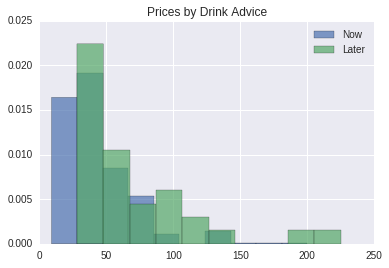

In [132]:
plt.hist(df[df.drink == 'now'].price,normed=True,alpha=.7)
plt.hist(df[df.drink == 'later'].price,normed=True,alpha=.7)
plt.legend(['Now','Later'])
plt.title('Prices by Drink Advice');

Wines that should be consumed later, when they mature, seems to be more expansive than the wines thath should be consumed now, fresh in other words.

### 1. ii.  Score Analysis

#### 1. ii. a. By Area

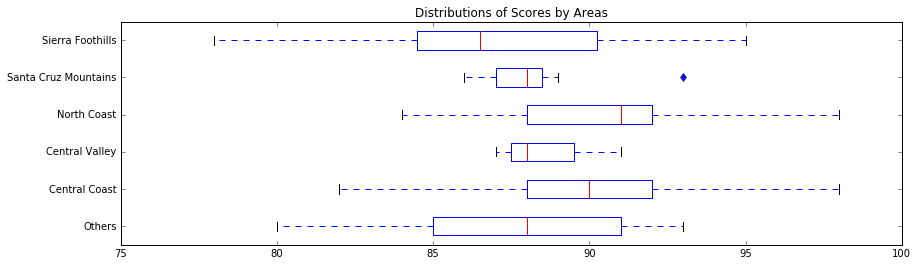

In [292]:
fig,ax = plt.subplots(figsize=(14,4))
ax.set_title('Distributions of Scores by Areas')
ax.boxplot([df[df.area == 'California']['score'].values,
            df[df.area == 'Central Coast']['score'].values,
            df[df.area == 'Central Valley']['score'].values,
            df[df.area == 'North Coast']['score'].values,
            df[df.area == 'Santa Cruz Mountains']['score'].values,
            df[df.area == 'Sierra Foothills']['score'].values]
           ,0,'gd',0,
           labels=['Others','Central Coast','Central Valley',
                             'North Coast','Santa Cruz Mountains','Sierra Foothills'],
           whis=1.5);

In [307]:
# Null Hypothesis: Wines produced in different areas does not differ by score
for e in df['area'].unique():
    if np.sum(df['area']==e) > 5:
        t,p = stat.ttest_ind(df[df.area == e]['score'],df[df.area != e]['score'], equal_var = False)
        print round(t,4),round(p,4),e


3.7799 0.0002 North Coast
-0.349 0.7276 Central Coast
-3.1792 0.0034 California
-1.9252 0.0859 Sierra Foothills
-2.0467 0.0845 Santa Cruz Mountains


North Coast wines have significantly better scores. California represents wines from wide variety of areas, so cannot comment on the data.

#### 1. 2. 2. By County

In [324]:
# Null Hypothesis: Wines produced in different counties does not differ by score
for e in df['county'].unique():
    if np.sum(df['county']==e) > 10:
        t,p = stat.ttest_ind(df[df.county == e]['score'],df[df.county != e]['score'], equal_var = False)
        print round(t,4),round(p,4),e

1.9017 0.0581 Napa
3.4943 0.0005 Sonoma
-0.5577 0.5791 Santa Barbara
-4.1019 0.0002 N/A
1.7243 0.0969 Monterey
-1.707 0.1028 San Luis Obispo


Sonoma County's wines have significanty higher scores. N/A  represents data from vide variety of  counties, so cannot comment on the data.

#### Drink Advice: Fresh or Mature

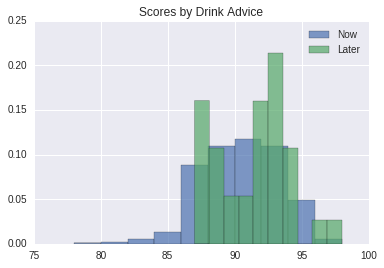

In [133]:
plt.hist(df[df.drink == 'now'].score,normed=True,alpha=.7)
plt.hist(df[df.drink == 'later'].score,normed=True,alpha=.7)
plt.legend(['Now','Later'])
plt.title('Scores by Drink Advice');

In [136]:
# Null Hypothesis: Wines that sould be consumed fresh and mature have same scores overall
t,p = stat.ttest_ind(df[df.drink == 'now'].score,df[df.drink == 'later'].score, equal_var = False)
t,p

(-3.1243476867714937, 0.0033491413527652904)

Evidence show that wines which should be consumed later (mature) have significantly higher scores than wines that should be consumed freshly.

### 1. 3. Production Analysis

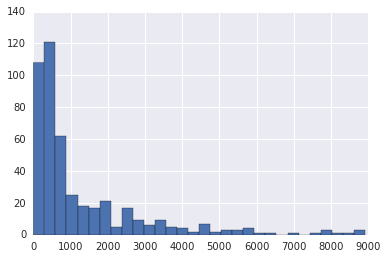

In [384]:
plt.hist(df.cases[df.cases<10000],bins=30);

Data is higly skewed to the right and has lots of outliers. So a simple heuristic will do.

## 2. AVA wines are better?

In [401]:
df.groupby('isava').mean()

,id,year,cases,price,score
isava,,,,,
No,279.916667,2007.281250,10759.93750,35.239583,88.802083
Yes,243.509901,2007.321782,2797.69802,47.821782,90.349010


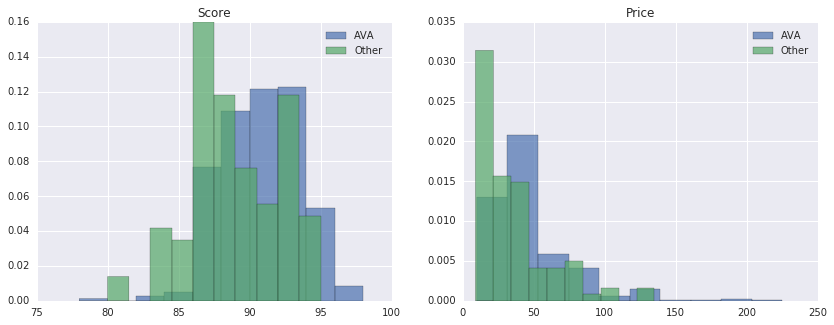

In [438]:
fig,ax = plt.subplots(1,2,figsize=(14,5))
ax[0].hist(df[df.isava=='Yes']['score'],normed=True,alpha=.7)
ax[0].hist(df[df.isava=='No']['score'],normed=True,alpha=.7)
ax[0].legend(['AVA','Other'])
ax[0].set_title('Score')
ax[1].hist(df[df.isava=='Yes']['price'],normed=True,alpha=.7)
ax[1].hist(df[df.isava=='No']['price'],normed=True,alpha=.7)
ax[1].legend(['AVA','Other'])
ax[1].set_title('Price');

In [426]:
# Null Hypothesis: Wines produced from AVA grapes and other area's grapes score the same
t,p = stat.ttest_ind(df[df.isava == 'Yes']['score'],df[df.isava == 'No']['score'], equal_var = False)
print round(t,4),round(p,4)

4.2587 0.0


In [430]:
# Null Hypothesis: Wines produced from AVA grapes and other area's grapes value the same
t,p = stat.ttest_ind(df[df.isava == 'Yes']['price'],df[df.isava == 'No']['price'], equal_var = False)
print round(t,4),round(p,4)

4.1864 0.0


Wines produced from AVA grapes are significantly more expensive and have higher scores than wines with the other grapes.

## 3. Comparing Red or White Wines

In [433]:
df.groupby('color').mean()

,id,year,cases,price,score
color,,,,,
Red,258.112392,2007.314121,2984.167147,49.178674,89.988473
White,233.235294,2007.313725,7370.705882,36.849673,90.196078


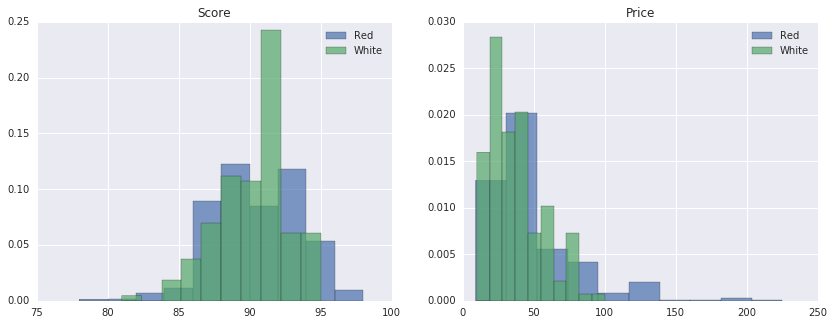

In [439]:
fig,ax = plt.subplots(1,2,figsize=(14,5))
ax[0].hist(df[df.color=='Red']['score'],normed=True,alpha=.7)
ax[0].hist(df[df.color=='White']['score'],normed=True,alpha=.7)
ax[0].legend(['Red','White'])
ax[0].set_title('Score')
ax[1].hist(df[df.color=='Red']['price'],normed=True,alpha=.7)
ax[1].hist(df[df.color=='White']['price'],normed=True,alpha=.7)
ax[1].legend(['Red','White'])
ax[1].set_title('Price');

In [440]:
# Null Hypothesis: White wines and red wines have same scores
t,p = stat.ttest_ind(df[df.color == 'Red']['score'],df[df.color == 'White']['score'], equal_var = False)
print round(t,4),round(p,4)

-0.7799 0.436


In [441]:
# Null Hypothesis: White wines and red wines cost the same
t,p = stat.ttest_ind(df[df.color == 'Red']['price'],df[df.color == 'White']['price'], equal_var = False)
print round(t,4),round(p,4)

5.3845 0.0


There is no statistically significant results that states white and red wines have the same scores.
On the other hand, red wines are statistically more expensive than the white wines.

# Predictive Analysis

## Preaparing the Data

In [67]:
# create binary values for score by using median
sum(df.score<90)
sum(df.score>90)
pd.cut(df.score,[0,90,100]) 
df['score_bin'] = pd.get_dummies(df.score>90).values[:,1]

In [163]:
df.columns

Index([u'id', u'grape', u'color', u'name', u'area', u'county', u'winery',
       u'appelation', u'isava', u'year', u'drink', u'cases', u'price',
       u'score', u'score_bin'],
      dtype='object')

In [292]:
# create dummies
d_grape = pd.get_dummies(df.grape,prefix='d')
d_color = pd.get_dummies(df.color,prefix='d')
d_county = pd.get_dummies(df.county,prefix='d')
# d_area = pd.get_dummies(df.area ,prefix='d')
d_isava = pd.get_dummies(df.isava ,prefix='d')
d_drink = pd.get_dummies(df.drink ,prefix='d')

n_df = pd.concat( [d_grape ,d_color ,d_county ,d_isava ,d_drink,df.cases,df.price,df.score,df.score_bin],axis=1 )
n_df.head()

,d_Barbera,d_Cabernet Franc,d_Cabernet Sauvingnon,d_Chardonnay,d_Grenache,d_Malbec,d_Marsanne,d_Merlot,d_Petite Sirah,d_Pinot Noir,...,d_Sonoma,d_Yolo,d_No,d_Yes,d_later,d_now,cases,price,score,score_bin
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,275,44,93,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,480,35,93,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,2700,40,91,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,525,38,89,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,275,44,88,0.0


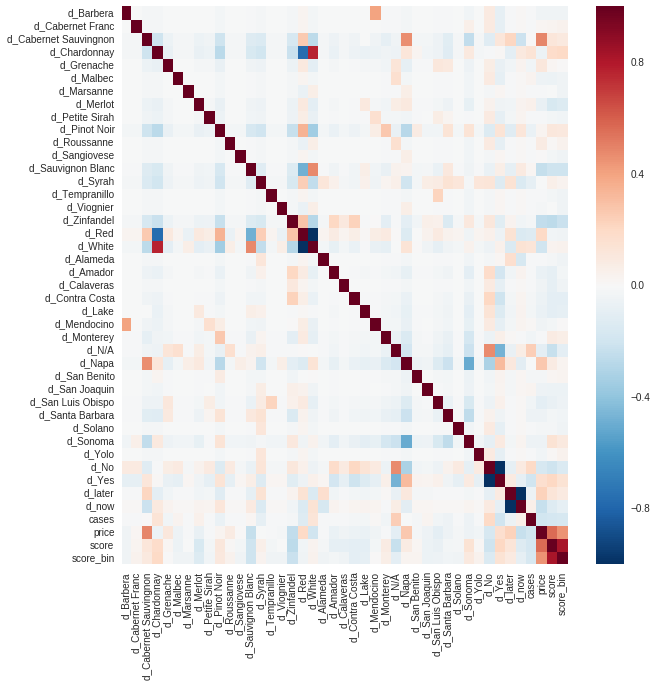

In [176]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
corr = n_df.corr()
sns.heatmap(corr)
plt.show()

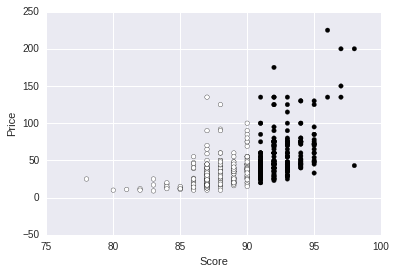

In [107]:
plt.scatter(df.score,df.price,c=df.score_bin)
plt.xlabel('Score')
plt.ylabel('Price');

There is a positive relationship between price and score as expected.

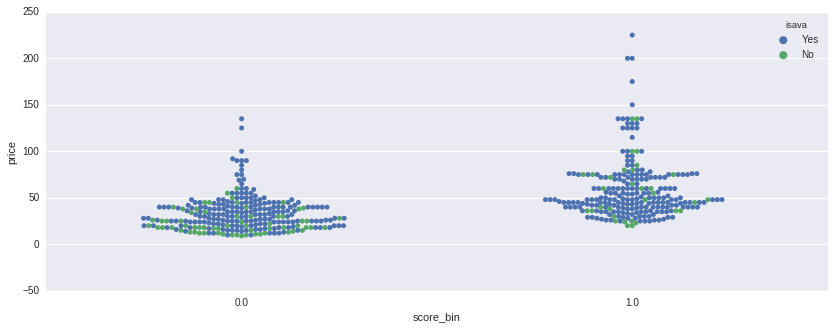

In [139]:
fig,ax = plt.subplots(1,1,figsize=(14,5))
sns.swarmplot(x="score_bin", y="price", hue="isava", data=df);

Another way to see the relationship between price, score and AVA.

In [467]:
# normalize features
norm_cases = df.cases.map(lambda x: (x-np.mean(df.cases))/np.std(df.cases))
norm_price = df.price.map(lambda x: (x-np.mean(df.price))/np.std(df.price))

In [481]:
# n_df = pd.concat( [d_grape ,d_color ,d_county ,d_isava ,d_drink,df.cases,df.price,df.score,df.score_bin],axis=1 )
n_df = pd.concat( [d_grape ,d_color ,d_county ,d_isava ,d_drink,norm_cases,norm_price,df.score,df.score_bin],axis=1 )

y = n_df['score_bin'].values
x = n_df.drop(['score','score_bin'], axis=1).values

In [482]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

#### Decision Tree

In [483]:
from sklearn import tree
model = tree.DecisionTreeClassifier(max_depth=3)

#train the classifier using the training data
model.fit(X_train, y_train)

predictions = model.predict(X_test)

# lets see how accurate our classfier was on the testing set
from sklearn.metrics import accuracy_score

print accuracy_score(y_test, predictions)
print model.score( X_train , y_train ), model.score( X_test , y_test )

0.751515151515
0.761194029851 0.751515151515


In [484]:
from sklearn.externals.six import StringIO
import pydot
dot_data = StringIO()
tree.export_graphviz(model,
                        out_file = dot_data,
                        feature_names = n_df.drop(['score','score_bin'], axis=1).columns.values,
                        class_names = ['low','high'],
                        filled = True, rounded = True,
                        impurity = False)

graph = pydot.graph_from_dot_data(dot_data.getvalue())
graph.write_pdf('tree.pdf')

True

In [485]:
from IPython.display import IFrame
IFrame("tree.pdf", width=800, height=400)

#### Logistic Regression

In [486]:
from sklearn import linear_model

model = linear_model.LogisticRegression()

model.fit(X_train, y_train)

print model.score( X_train , y_train ) , model.score( X_test , y_test )

0.782089552239 0.745454545455


#### Linear Regression

In [487]:
# n_df = pd.concat( [d_grape ,d_color ,d_county ,d_isava ,d_drink,norm_cases,norm_price,df.score,df.score_bin],axis=1 )
y = n_df[['score']].values
x = pd.concat([norm_price],axis=1).values
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

('Coefficients: ', array([[ 1.70388081]]))
Mean squared error: 4.75
Variance score: 0.36


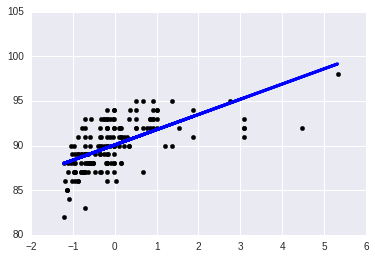

In [490]:
from sklearn import linear_model
# Create linear regression object
model = linear_model.LinearRegression()

# Train the model using the training sets
model.fit(X_train, y_train)

# The coefficients
print('Coefficients: ', model.coef_)

# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((model.predict(X_test) - y_test) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % model.score(X_test, y_test))

# Plot outputs
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, model.predict(X_test), color='blue',
         linewidth=3);
